In [2]:
!pip install torch torchvision diffusers transformers transparent-background

  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of albumentations to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.5/41.5 kB 3.1 MB/s eta 0:00:00
INFO: pip is still looking at multiple versions of albumentations to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.1 MB/s eta 0:00:00
   ━━━━━━━

In [3]:
# Import required modules
import os
import torch
import shutil
from PIL import ImageOps
from diffusers import DiffusionPipeline
from diffusers.utils import load_image
from transparent_background import Remover
from google.colab import files
from IPython.display import display, Image


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [4]:
# Setting up the model - using yahoo background generation (open source)
MODEL_NAME = "yahoo-inc/photo-background-generation"
MODEL_CACHE = "model-cache"
device = "cuda" if torch.cuda.is_available() else "cpu"
float_datatype = torch.float16 if device == "cuda" else torch.float32

pipe = DiffusionPipeline.from_pretrained(
    MODEL_NAME,
    cache_dir=MODEL_CACHE,
    torch_dtype=float_datatype,
    custom_pipeline=MODEL_NAME,
).to(device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/692 [00:00<?, ?B/s]

pipeline.py:   0%|          | 0.00/67.0k [00:00<?, ?B/s]

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/973 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/211 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.88k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/765 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/diffusers/loaders/lora_pipeline.py:3811: FutureWarning: `LoraLoaderMixin` is deprecated and will be removed in version 1.0.0. LoraLoaderMixin is deprecated and this will be removed in a future version. Please use `StableDiffusionLoraLoaderMixin`, instead.
  deprecate("LoraLoaderMixin", "1.0.0", deprecation_message)


In [25]:
# Function that use for modify the image and utility

def resize_with_padding(img, expected_size=(1024, 1024)):
    img.thumbnail(expected_size)
    delta_width = expected_size[0] - img.size[0]
    delta_height = expected_size[1] - img.size[1]
    padding = (
        delta_width // 2,
        delta_height // 2,
        delta_width - delta_width // 2,
        delta_height - delta_height // 2,
    )
    return ImageOps.expand(img, padding)

def generate_image(prompt, negative_prompt, image_path, num_outputs=1, steps=30, seed=None, scale=1.0):
    if seed is None:
        seed = int.from_bytes(os.urandom(3), "big")
    print(f"Using seed: {seed}")

    generator = torch.Generator(device=device).manual_seed(seed)

    img = load_image(image_path).convert("RGB")
    img = resize_with_padding(img)

    remover = Remover(mode="base")
    fg_mask = remover.process(img, type="map")
    mask = ImageOps.invert(fg_mask)

    with torch.autocast(device):
        output = pipe(
            prompt=[prompt] * num_outputs,
            negative_prompt=[negative_prompt] * num_outputs,
            generator=generator,
            num_inference_steps=steps,
            controlnet_conditioning_scale=scale,
            guess_mode=False,
            image=img,
            mask_image=mask,
            control_image=mask,
        )

    result_paths = []
    for i, im in enumerate(output.images):
        output_path = f"output_{i}.png"
        im.save(output_path)
        result_paths.append(output_path)

    return result_paths


In [26]:
# Upload Image to System for Generation (This we need to use main image that we want to add background)
uploaded = files.upload()
image_path = list(uploaded.keys())[0]


Saving Screenshot 2025-04-17 at 18-38-24 Skincare Samples For Sensitive Breakout Prone Skin Sabbia Co.png to Screenshot 2025-04-17 at 18-38-24 Skincare Samples For Sensitive Breakout Prone Skin Sabbia Co (1).png


In [ ]:
# Prompting
prompt = ("")

#negative value is the value that you dont want to see in the image or generated into it.
negative_prompt = "3d, cgi, render, bad quality, normal quality"
num_outputs = 1
num_inference_steps = 30
seed = None  # or set to a number like 123
scale = 1.0


Using seed: 13525628
Settings -> Mode=base, Device=cuda:0, Torchscript=disabled


  0%|          | 0/30 [00:00<?, ?it/s]

Settings -> Mode=base, Device=cuda:0, Torchscript=disabled


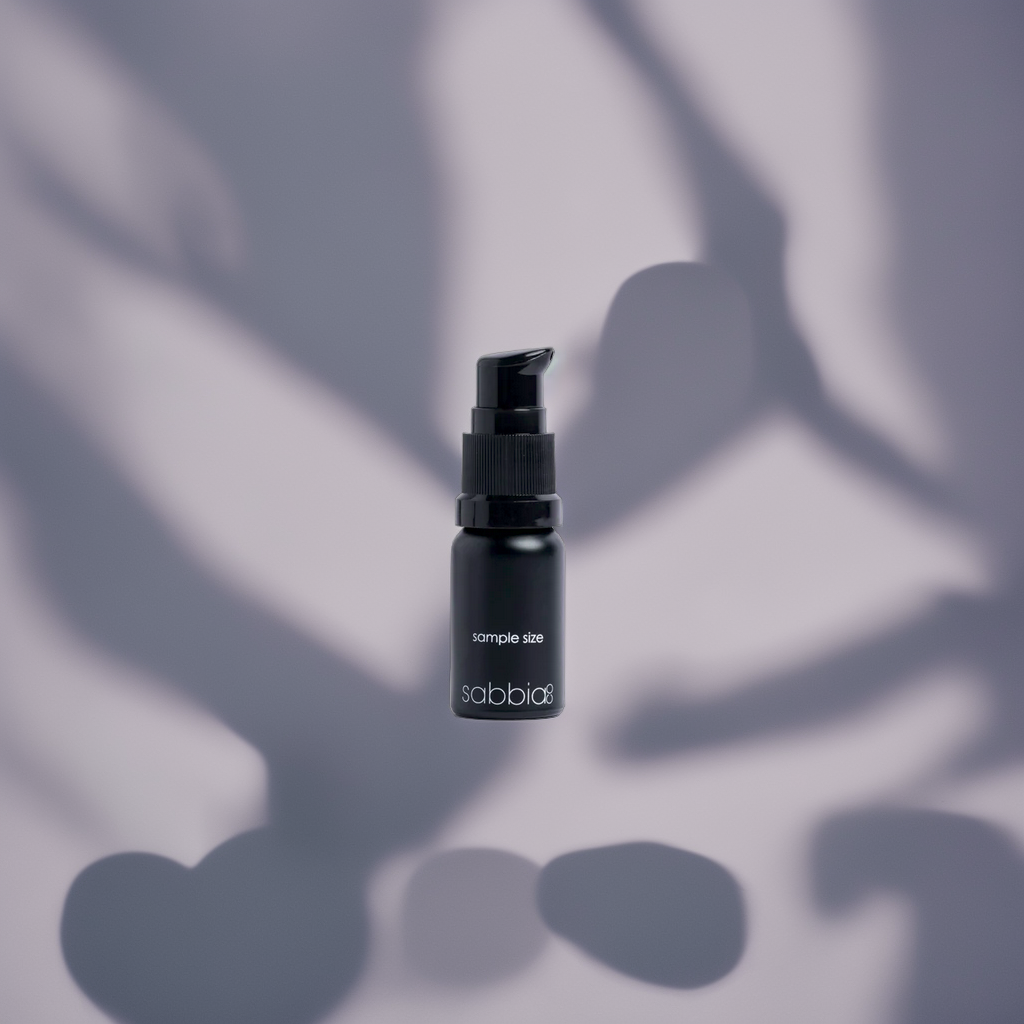

In [28]:
# Start generate new image with background
results = generate_image(
    prompt=prompt,
    negative_prompt=negative_prompt,
    image_path=image_path,
    num_outputs=num_outputs,
    steps=num_inference_steps,
    seed=seed,
    scale=scale,
)



from PIL import Image
from IPython.display import display, Image as IPyImage


# Load the original product image and resize it
original = resize_with_padding(load_image(image_path).convert("RGBA"))

# Load the AI-generated background
generated = Image.open(results[0]).convert("RGBA")

# Recreate the foreground mask (product only)
remover = Remover(mode="base")
fg_mask = remover.process(original.convert("RGB"), type="map").convert("L")

# Create an image with only the product (and original text/logo), transparent background
product_only = Image.composite(original, Image.new("RGBA", original.size), fg_mask)

# Paste the product back onto the generated background
final_image = Image.alpha_composite(generated, product_only)

# Save and display final result
final_path = "final_result.png"
final_image.save(final_path)
display(IPyImage(filename=final_path))

